In [22]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [91]:
data = pd.read_csv('03_Владивосток.csv')

In [92]:
data

,Год,янв,фев,мар,апр,май,июн,июл,авг,сен,окт,ноя,дек,средняя
0,1872,-18.0,-11.6,-2.6,3.6,8.8,13.8,18.1,18.5,15.4,9.6,-0.1,-10.4,3.8
1,1873,-17.4,-12.7,-5.7,2.2,7.9,12.6,18.0,19.9,14.0,7.6,-2.1,-11.2,2.8
2,1874,-12.6,-8.8,-3.1,4.8,8.8,14.4,20.1,21.0,15.9,8.2,-2.2,-9.8,4.7
3,1875,-13.0,-10.3,-0.5,3.0,9.2,14.6,20.0,19.6,17.0,9.1,-1.8,-10.3,4.7
4,1876,-14.6,-8.7,-2.1,5.3,10.7,12.8,21.0,21.8,15.0,10.8,-2.9,-13.0,4.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143,2015,-10.5,-7.1,0.1,5.1,10.7,13.9,18.6,20.2,17.0,8.9,-2.6,-6.1,5.7
144,2016,-12.4,-8.3,0.3,5.2,11.0,12.7,18.1,21.4,16.5,7.7,-4.5,-7.7,5.0
145,2017,-9.8,-6.6,0.4,6.8,11.1,13.7,20.3,19.6,16.9,8.5,-1.5,-11.1,5.7
146,2018,-12.7,-10.6,-2.2,5.6,10.2,13.5,18.5,19.9,16.4,10.4,1.0,-7.7,5.2


In [80]:
#data = data.replace(999.9, np.NaN).dropna()

In [26]:
date_first, date_last = data['Год'].min(), data['Год'].max()

In [27]:
columns = data.columns[1:]

## Интерполяционный многочлен Лагранжа


$$
f(x) = \sum_{i=1}^{n}\frac{\prod_{j\neq i}(x - x_j)}{\prod_{j\neq i}(x_i - x_j)}y_i
$$

In [28]:
def make_lagrange_polynom(x, y, p):
    res = 0
    for i in range(len(x)):
        frac = 1
        for j in range(len(x)):
            if j != i and y[j] != 999.9:
                frac *= (p - x[j])/(x[i] - x[j])
        res += frac*y[i]
    return res

In [37]:
def interpolate_weather(data, year, month, method, period):
    date_first, date_last = data['Год'].min(), data['Год'].max()
    start = year - date_first
    end = start + period
    grid = np.arange(year, year+period+0.1, 0.1)
    x, y = data['Год'][start:end+1].values, data[month][start:end+1].values
    vals = list(map(lambda p: method(x, y, p), grid))
    
    plt.figure(figsize=(10, 7))
    plt.plot(grid, vals, label=month)
    plt.plot(x, y, marker='o', linestyle='dashed')
    plt.legend()

[2017 2018 2019] [-11.1  -7.7 999.9]


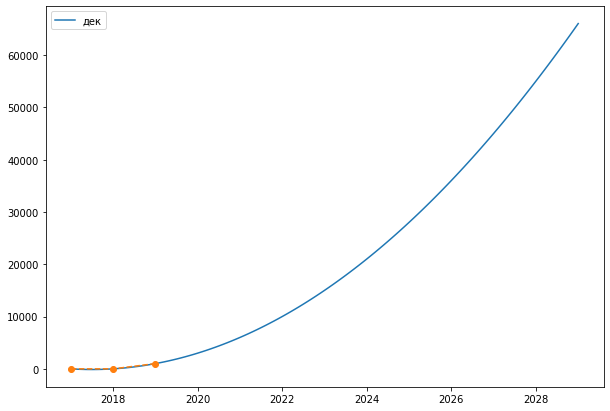

In [32]:
interpolate_weather(data, 2017, 'дек', make_lagrange_polynom, 12)

## Формулы Ньютона

<img src=https://wikimedia.org/api/rest_v1/media/math/render/svg/51da6a1d09f9d7fe10a68e75fdced797c6dc78cd />

In [59]:
def compute_binom(q, n):
        res = 1
        for i in range(n):
            res *= (q-i)/(i+1)
        return res
    
    
def fin_diff(y, n):
    fin_diffs = [y]
    for i in range(n):
        fin_diffs.append([])
        for j in range(n-i):
            fin_diffs[-1].append(fin_diffs[-2][j+1] - fin_diffs[-2][j])
    return fin_diffs

def make_neuton_polynom_forward(x, y, p):
    h = x[1] - x[0]
    q = (p - x[0])/h
    n = len(x)-1
    fin_diffs = fin_diff(y, n)
    
    res = y[0]
    for i in range(1, n+1):
        res += compute_binom(q, i)*fin_diffs[i][0]
    return res

def make_neuton_polynom_backward(x, y, p):
    h = x[1] - x[0]
    q = (p - x[-1])/h
    n = len(x)-1
    fin_diffs = fin_diff(y, n)
    
    res = y[-1]
    for i in range(1, n+1):
        res += compute_binom(q+i-1, i)*fin_diffs[i][-1]
    return res

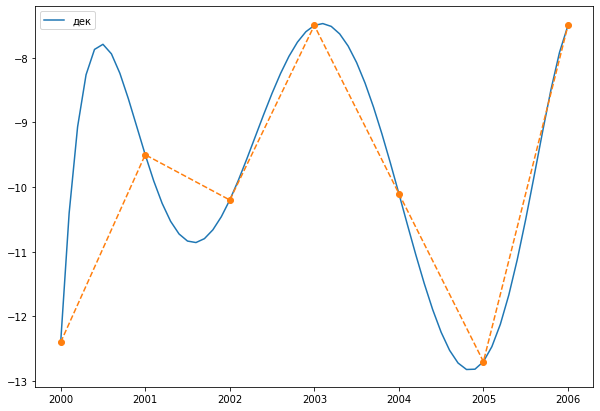

In [60]:
interpolate_weather(data, 2000, 'дек', make_neuton_polynom_forward, 6)

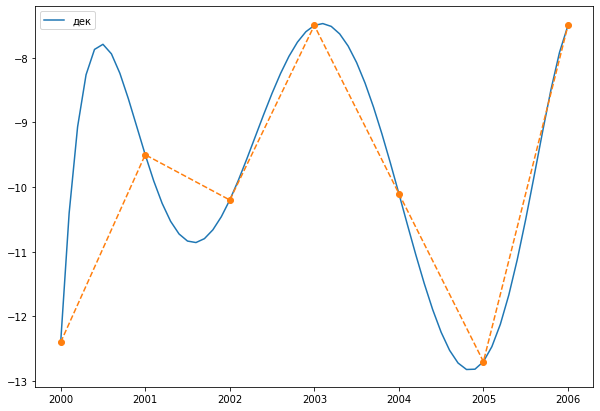

In [61]:
interpolate_weather(data, 2000, 'дек', make_neuton_polynom_backward, 6)

<img src=https://s1.slide-share.ru/s_slide/0b36ed377d9196a4ac68f0a7383cdcc7/293d5620-afb2-428f-817c-c449fa2a3abd.jpeg />

In [67]:
def approx_polynom(x, y, k):
    A = np.zeros(shape=(k+1, k+1))
    
    deg_sum = []
    for i in range(2*k + 1):
        deg_sum.append(sum(j**i for j in x))
        
    for i in range(k+1):
        for j in range(k+1):
            A[i][j] = deg_sum[i + j]
            
    b = np.array([sum(x[i]**j * y[i] for i in range(len(x))) for j in range(k+1)])
    
    return np.dot(np.linalg.inv(A), b)


def compute_polynom(coefs, p):
    res = 0
    for i, coef in enumerate(coefs):
        res += coef*p**i
    return res

In [68]:
coefs = approx_polynom(list(range(len(data['янв']))), np.array(data['янв']), 3)

In [105]:
def interpolate_poly(month, deg):
    x = list(range(len(data[month])))
    y = list(data[month])
    if y[-1] == 999.9:
        y.pop()
        x.pop()
    coefs = approx_polynom(x, y, deg)
    
    plt.figure(figsize=(10, 7))
    plt.plot(np.array(x) + date_first, [compute_polynom(coefs, p) for p in x])
    plt.plot(np.array(x) + date_first, y, marker='o', linestyle='')
    plt.show()

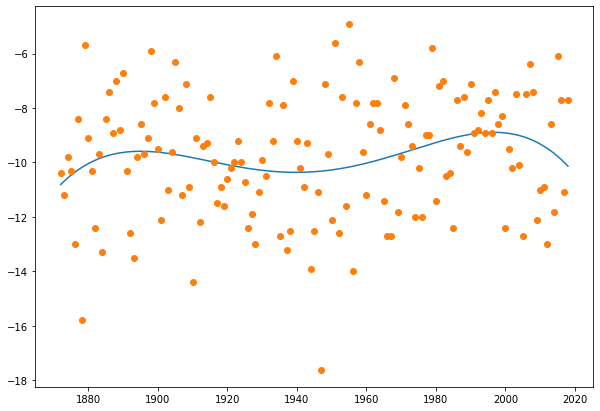

In [106]:
interpolate_poly('дек', 4)